# Data Science 214 AF Project 2024 

Lydia Laubscher : 27357570  
Tiaan Viviers : 26067404  
Abraham de Villiers : 24560502

In [601]:
#import libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from scipy import stats

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler

# Exploratory Data Analysis

In [603]:
df = pd.read_csv('data/ShopAlot.csv')
np.random.seed(18)
print("Shape: ", df.shape)
print(df.isna().sum())

Shape:  (15000, 22)
Sales                  0
Month                  0
AgeInMonths            0
ProfileInMonths        0
Subscribed         10935
NumPrevOrders          0
AvgSpend               0
POSR                   0
OPR                    0
Online                 0
Discount               0
ShippingOption         0
Platform               0
Payment                0
Ad_1                   0
Ad_2                   0
Ad_3                   0
SocialMedia         9050
ShippingPayment        0
Category               0
DayOfWeek              0
Province               0
dtype: int64


In [779]:
data = df.dropna()
print("New Shape: ", data.shape)

New Shape:  (1873, 22)


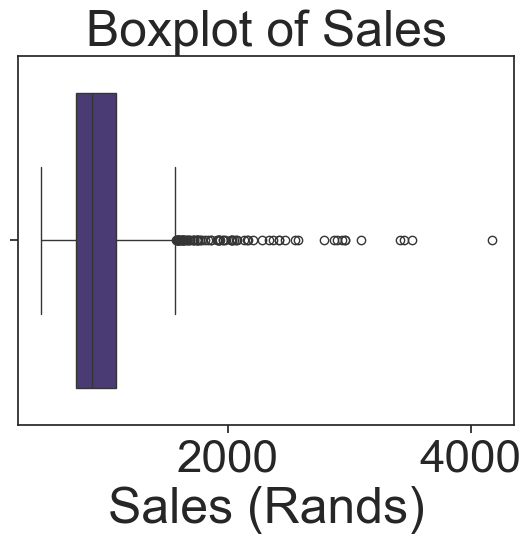

In [607]:
sns.boxplot(x=data['Sales'])
plt.title('Boxplot of Sales')
plt.xlabel('Sales (Rands)')
plt.show()

### UNIVARIATE INVESTIGATION:

### Numerical Correlations:

In [808]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

<Axes: >

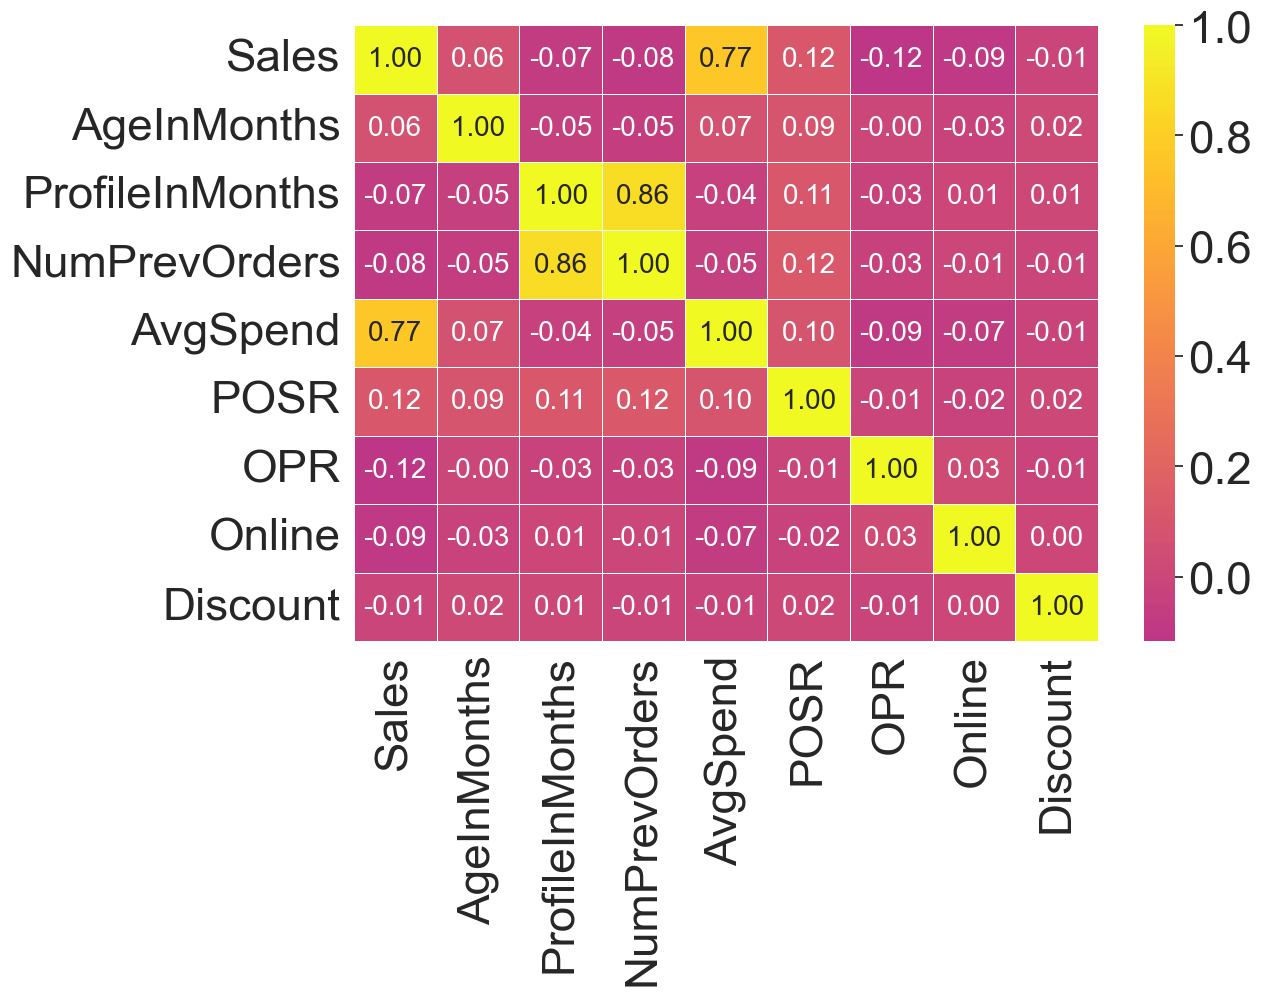

In [812]:
numerical_data = data[['Sales', 'AgeInMonths', 'ProfileInMonths', 'NumPrevOrders', 'AvgSpend', 'POSR', 'OPR', 'Online', 'Discount']]
plt.figure(figsize = (12,8))
sns.heatmap(numerical_data.corr(), annot = True, cmap='plasma', fmt = '.2f', linewidths=.5, center = 0, annot_kws={"size": 20})

Sales and AvgSpend have a high positive correlation: 0.77. This interaction is due to the fact that a client who averagely spent more (in Rands) on all previous purchases, are likely to spend relatively the same amount on a new purchase.  
  
NumPrevOrders and ProfileInMonths have a high positive correlation: 0.86. ProfileInMonths is dependent on NumPreOrders because the longer a client has had a profile, the more purchases they are likely to have made. We will create an interaction term for ProfileInMonths and NumPreOrders for the linear model.

In [635]:
data.loc[:, 'PIM_NPR_interaction'] = data['ProfileInMonths'] * data['NumPrevOrders']

### Categorical Correlations:

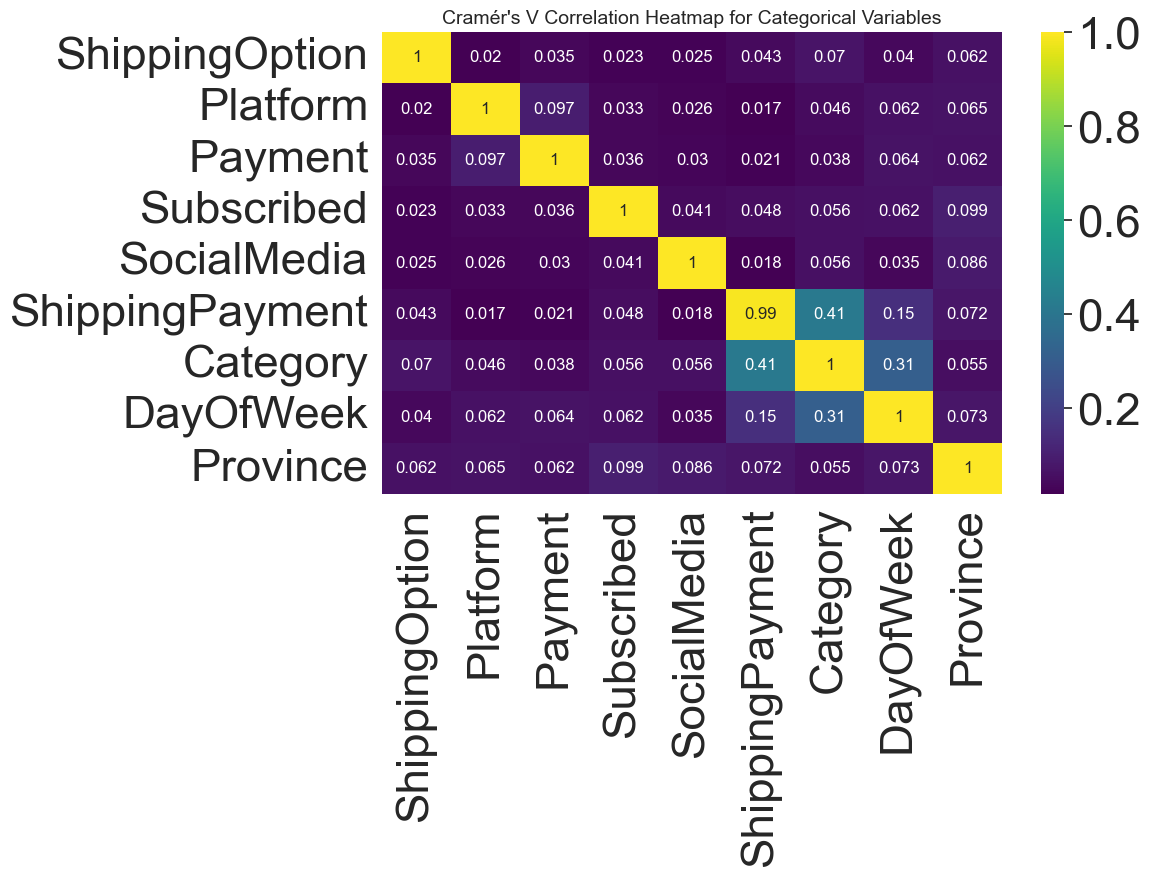

In [818]:
# Compute Cramér's V statistic
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Cramér's V correlation matrix
def correlation_matrix(data, cols):
    n = len(cols)
    v = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            v[i, j] = cramers_v(data[cols[i]], data[cols[j]])
            v[j, i] = v[i, j]
    
    return v
    
categorical = ['ShippingOption', 'Platform', 'Payment', 'Subscribed', 'SocialMedia', 'ShippingPayment', 'Category', 'DayOfWeek', 'Province']
corr_matrix = correlation_matrix(data, categorical)

sns.heatmap(corr_matrix, annot = True, xticklabels = categorical, yticklabels = categorical, cmap = 'viridis', annot_kws={"size": 12})
plt.title("Cramér's V Correlation Heatmap for Categorical Variables")
plt.show()

Category and ShippingPayment are moderately associated with a Cramér's V of 0.41. Product categories could influence clients' shipping preference, more expensive items will require more secure and safe shipping methods.  
Category is also moderately associated with DayOfWeek with a Cramér's V of 0.31. Clients purchase different types of products depending on what day of the week. Groceries and cleaning supplies are more likely bought during the week, while clothing and leasure items might be purchased on weekends.

## Sales:

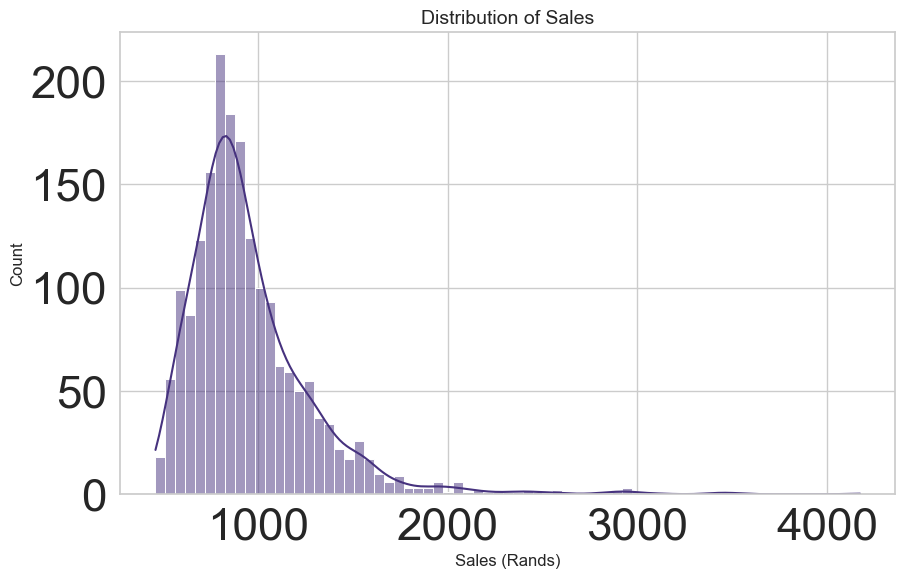

In [823]:
sns.histplot(data['Sales'], kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales (Rands)')
plt.show()

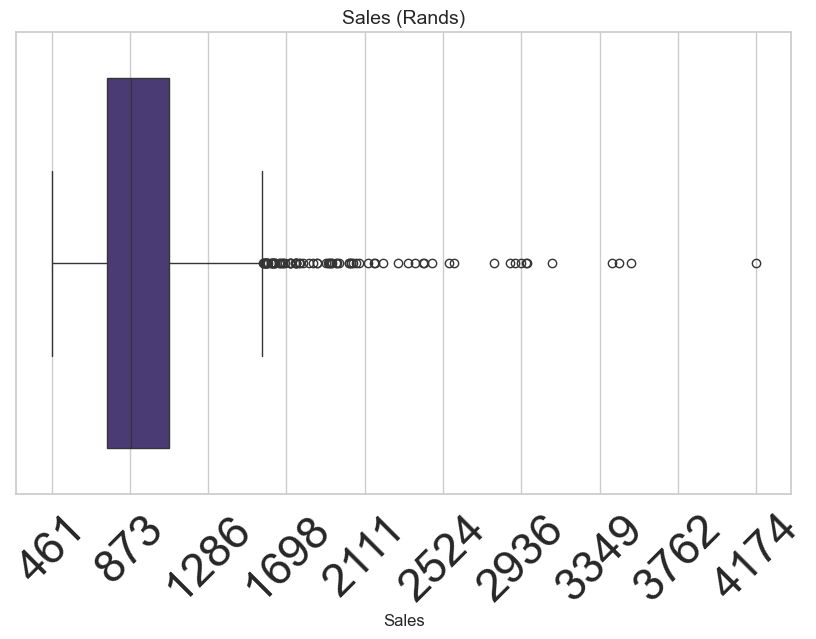

0.00     460.52
0.25     752.55
0.50     879.06
0.75    1079.53
1.00    4174.26
Name: Sales, dtype: float64


In [825]:
sns.boxplot(x = data['Sales'])
plt.title('Sales (Rands)')
ticks = np.linspace(data['Sales'].min(), data['Sales'].max(), num=10)
plt.xticks(ticks, rotation=45)
plt.show()
quantiles = data['Sales'].quantile([0, 0.25, 0.5, 0.75, 1])
print(quantiles)

Sales is heavily skewed to the right with minimum: 460.52, median: 879.06 and maximum: 4174.26. To help reduce the skewness, we will perform a log transformation on this variable because linear regression performs better with normally distributed data.

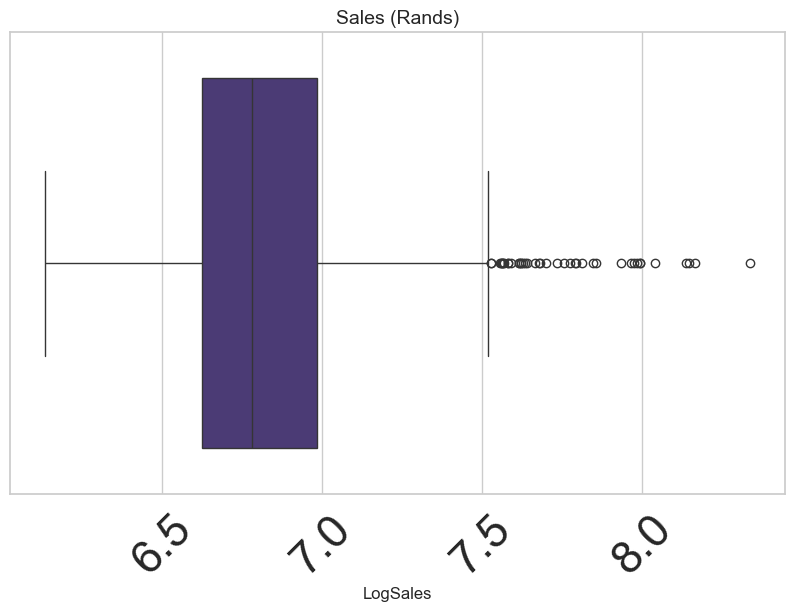

0.00    6.134525
0.25    6.624795
0.50    6.779990
0.75    6.985207
1.00    8.336932
Name: LogSales, dtype: float64


In [830]:
data_new['LogSales'] = np.log1p(data_new['Sales'])
sns.boxplot(x = data_new['LogSales'])
plt.title('Sales (Rands)')
ticks = np.linspace(data_new['LogSales'].min(), data_new['LogSales'].max(), num=10)
plt.xticks(rotation=45)
plt.show()
quantiles = data_new['LogSales'].quantile([0, 0.25, 0.5, 0.75, 1])
print(quantiles)

### Visualising the relationship of Sales with all other numerical variables

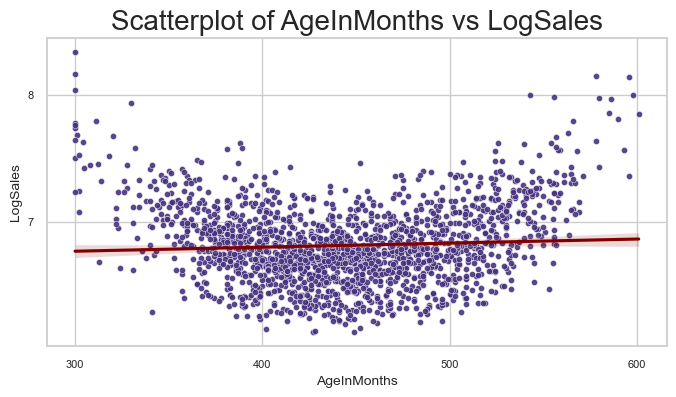

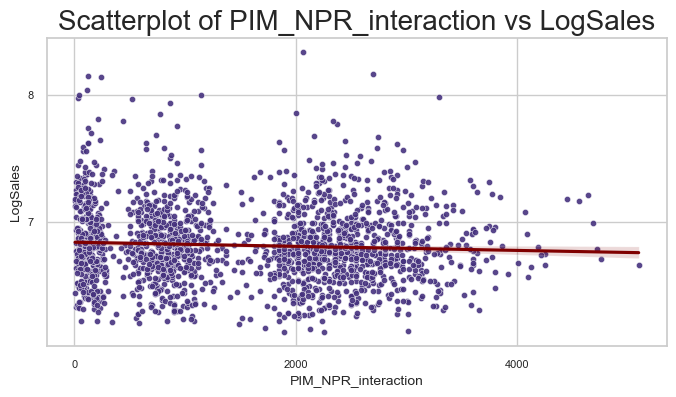

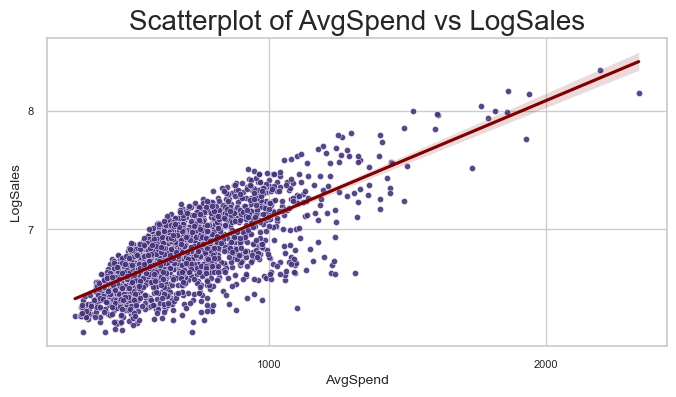

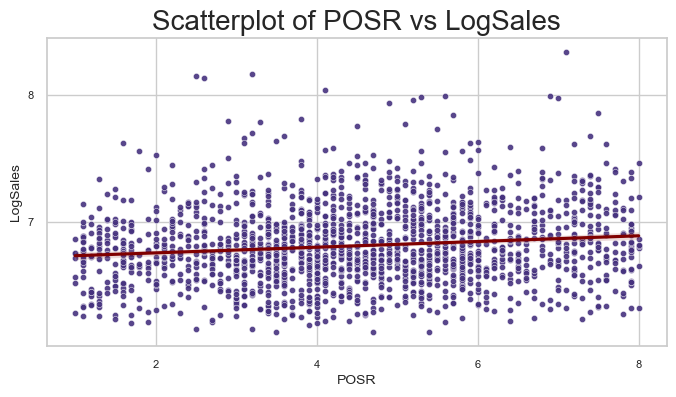

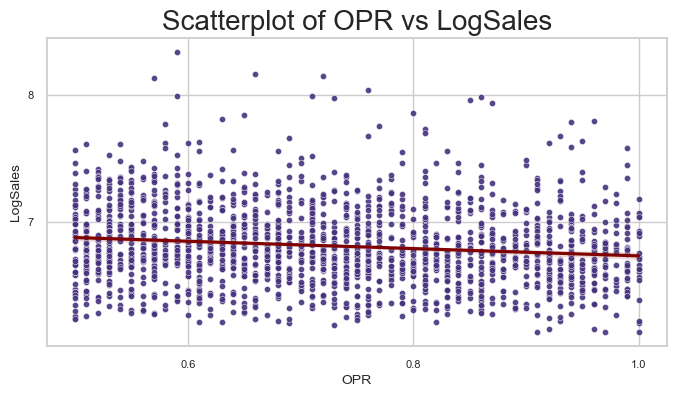

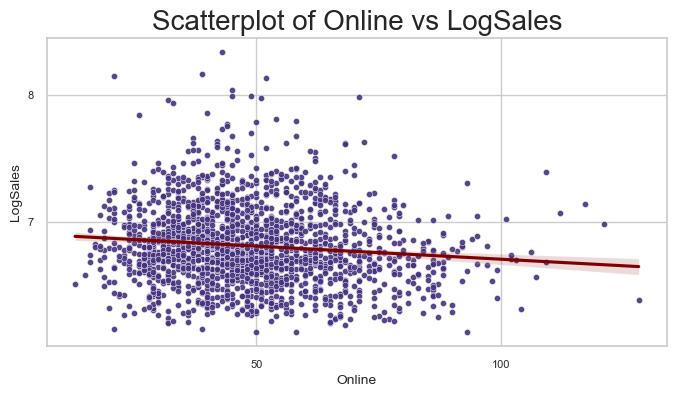

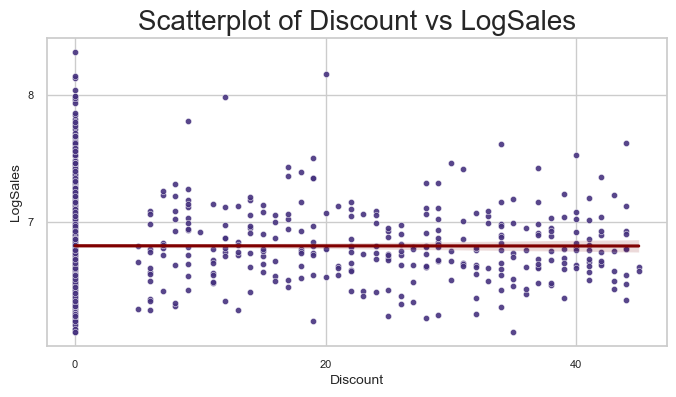

In [832]:
numerical_data = data_new[['LogSales', 'AgeInMonths', 'PIM_NPR_interaction', 'AvgSpend', 'POSR', 'OPR', 'Online', 'Discount']]

for var in numerical_data:
    if var == 'LogSales':
        continue
    
    plt.figure(figsize=(8, 4)) 
    sns.scatterplot(data=data_new, x=var, y='LogSales', alpha=0.9, marker='o', s=20)
    sns.regplot(data=data_new, x=var, y='LogSales', scatter=False, color='maroon')
    
    plt.title(f"Scatterplot of {var} vs LogSales", fontsize=20)
    plt.xlabel(var, fontsize=10)  # Adjust x-axis label font size
    plt.ylabel("LogSales", fontsize=10)  # Adjust y-axis label font size
    
    # Adjust the font size for tick labels
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    plt.show()

While only AvgSpend vs LogSales show evidence of correlation, we get an idea of the linearity of relationships between LogSales and all other numerical predictors.  
The relationship between AgeInMonths and LogSales seems quadratic. To handle this, we will include a quadratic term for AgeInMonths in the model.  
All other relationships show no linear relationship.

In [784]:
data_new['AgeInMonths_Squared'] = data_new['AgeInMonths'] ** 2

## Month:

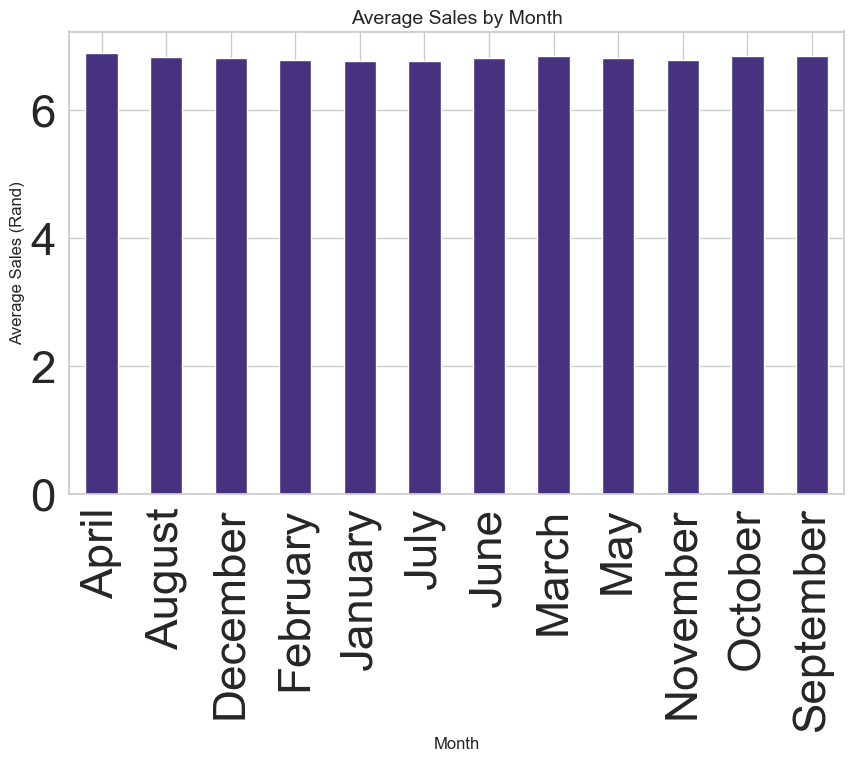

In [834]:
data_new.groupby('Month')['LogSales'].mean().plot(kind='bar')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales (Rand)')
plt.show()

Since average sales per month doesn't have high variation, we can group the months by seasons which agrees with the fact  
that products such as clothing suit different seasons.

## Seasons:

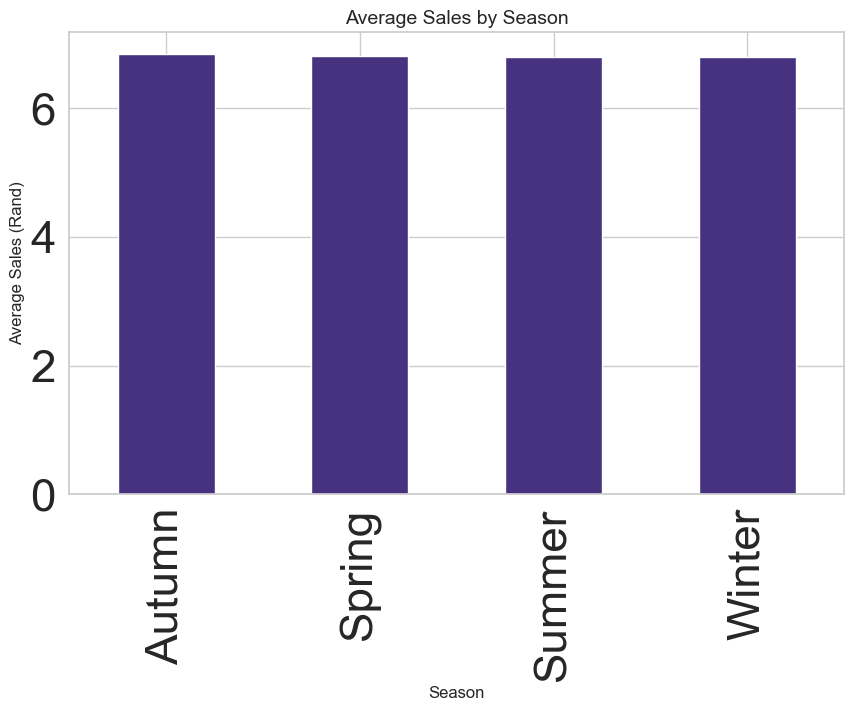

In [836]:
df_new = data_new.copy()
ssns_dict = {'January': 'Summer', 'February': 'Summer', 'March': 'Autumn', 'April': 'Autumn', 'May': 'Autumn', 'June': 'Winter', 'July': 'Winter', 
             'August': 'Winter', 'September': 'Spring', 'October': 'Spring', 'November': 'Spring', 'December': 'Summer'}
df_new['Season'] = df_new['Month'].apply(lambda x: ssns_dict[x])
df_new.drop(['Month'], axis=1, inplace= True)

df_new.groupby('Season')['LogSales'].mean().plot(kind='bar')
plt.title('Average Sales by Season')
plt.xlabel('Season')
plt.ylabel('Average Sales (Rand)')
plt.show()

## AgeInMonths_Squared:

Summary Statistics:
count      1873.000000
mean     200394.683930
std       51078.095701
min       90000.000000
25%      161604.000000
50%      195364.000000
75%      234256.000000
max      361201.000000
Name: AgeInMonths_Squared, dtype: float64

95% Confidence Interval for Mean: (198079.98353340113, 202709.3843256485)


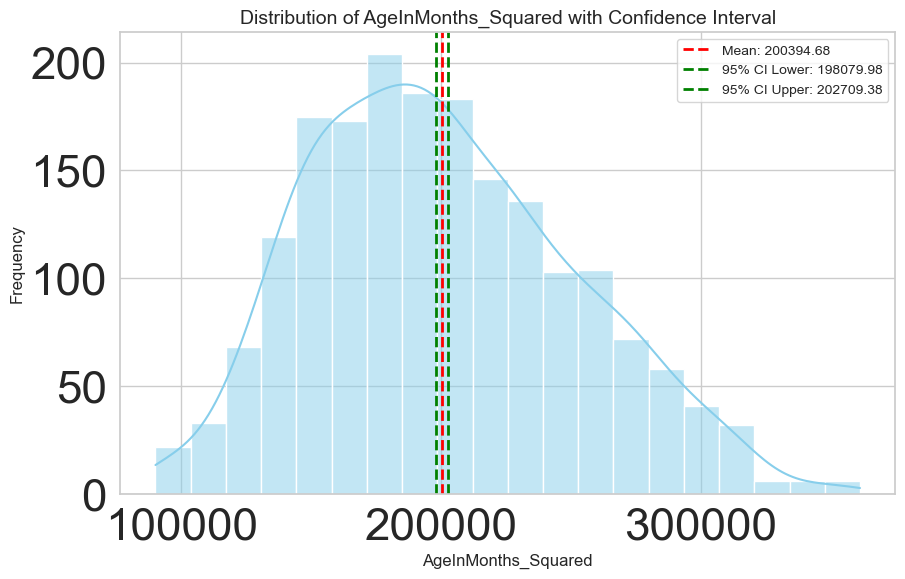

In [838]:
summary_stats = df_new['AgeInMonths_Squared'].describe()
print("Summary Statistics:")
print(summary_stats)

# Confidence Interval for Mean
mean = summary_stats['mean']
std_dev = summary_stats['std']
n = summary_stats['count']

confidence_level = 0.95
degrees_freedom = n - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean, scale=std_dev/np.sqrt(n))

print(f"\n95% Confidence Interval for Mean: {confidence_interval}")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_new['AgeInMonths_Squared'], bins=20, kde=True, color='skyblue')

# Mark mean and confidence interval
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Lower: {confidence_interval[0]:.2f}')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Upper: {confidence_interval[1]:.2f}')

plt.title('Distribution of AgeInMonths_Squared with Confidence Interval')
plt.xlabel('AgeInMonths_Squared')
plt.ylabel('Frequency')
plt.legend()
plt.show()

AgeInMonths is symmetrically distributed with no ouliers.

## PIM_NPR_interaction:

Summary Statistics:
count    1873.000000
mean     1553.600641
std      1073.361194
min         7.000000
25%       667.000000
50%      1596.000000
75%      2430.000000
max      5096.000000
Name: PIM_NPR_interaction, dtype: float64

95% Confidence Interval for Mean: (1504.959250558264, 1602.242030808527)


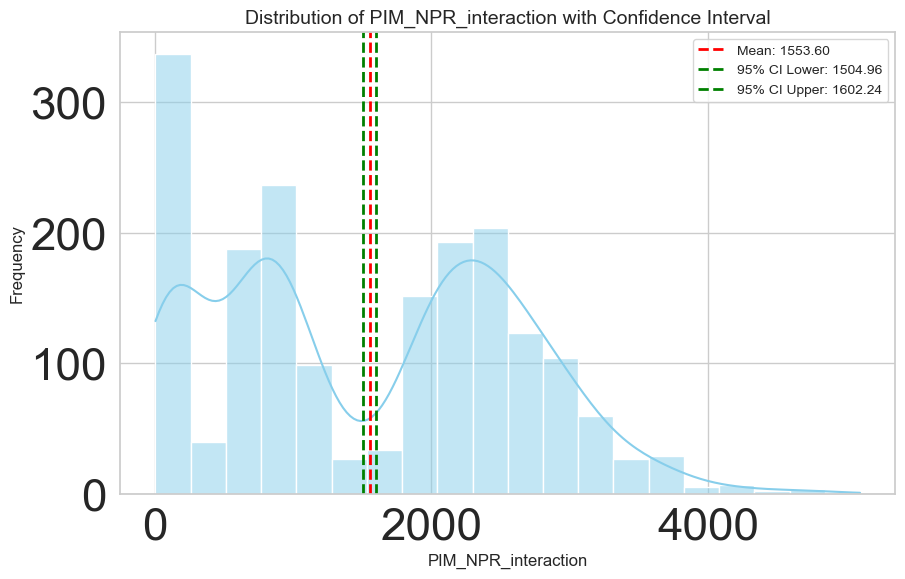

In [840]:
summary_stats = df_new['PIM_NPR_interaction'].describe()
print("Summary Statistics:")
print(summary_stats)

# Confidence Interval for Mean
mean = summary_stats['mean']
std_dev = summary_stats['std']
n = summary_stats['count']

confidence_level = 0.95
degrees_freedom = n - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean, scale=std_dev/np.sqrt(n))

print(f"\n95% Confidence Interval for Mean: {confidence_interval}")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_new['PIM_NPR_interaction'], bins=20, kde=True, color='skyblue')

# Mark mean and confidence interval
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Lower: {confidence_interval[0]:.2f}')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Upper: {confidence_interval[1]:.2f}')

plt.title('Distribution of PIM_NPR_interaction with Confidence Interval')
plt.xlabel('PIM_NPR_interaction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## AvgSpend:

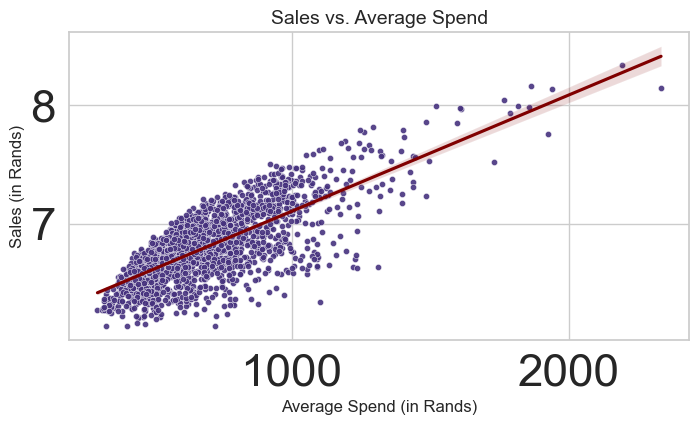

In [842]:
plt.figure(figsize=(8, 4)) 
sns.scatterplot(data=df_new, x='AvgSpend', y='LogSales', alpha=0.9, marker='o', s=20)
sns.regplot(data=df_new, x='AvgSpend', y='LogSales', scatter=False, color='maroon')
plt.title('Sales vs. Average Spend')
plt.xlabel('Average Spend (in Rands)')
plt.ylabel('Sales (in Rands)')
plt.show()

Summary Statistics:
count    1873.000000
mean      704.871708
std       228.181321
min       299.320000
25%       545.600000
50%       665.660000
75%       814.240000
max      2333.880000
Name: AvgSpend, dtype: float64

95% Confidence Interval for Mean: (694.5312408711893, 715.2121761069207)


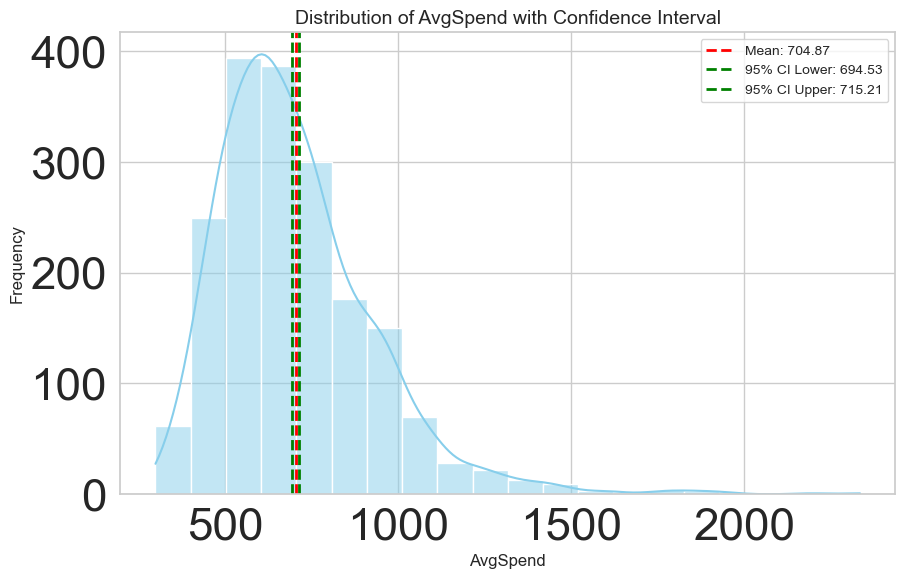

In [844]:
summary_stats = df_new['AvgSpend'].describe()
print("Summary Statistics:")
print(summary_stats)

# Confidence Interval for Mean
mean = summary_stats['mean']
std_dev = summary_stats['std']
n = summary_stats['count']

confidence_level = 0.95
degrees_freedom = n - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean, scale=std_dev/np.sqrt(n))

print(f"\n95% Confidence Interval for Mean: {confidence_interval}")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_new['AvgSpend'], bins=20, kde=True, color='skyblue')

# Mark mean and confidence interval
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Lower: {confidence_interval[0]:.2f}')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Upper: {confidence_interval[1]:.2f}')

plt.title('Distribution of AvgSpend with Confidence Interval')
plt.xlabel('AvgSpend')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## POSR:

Summary Statistics:
count    1873.000000
mean        4.492152
std         1.740013
min         1.000000
25%         3.300000
50%         4.500000
75%         5.700000
max         8.000000
Name: POSR, dtype: float64

95% Confidence Interval for Mean: (4.413299633268921, 4.571003623538339)


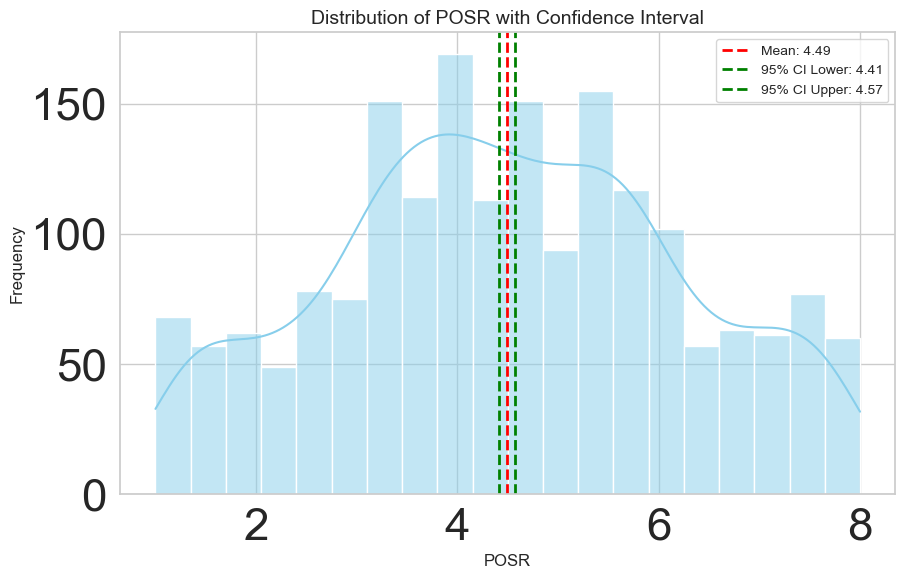

In [846]:
summary_stats = df_new['POSR'].describe()
print("Summary Statistics:")
print(summary_stats)

# Confidence Interval for Mean
mean = summary_stats['mean']
std_dev = summary_stats['std']
n = summary_stats['count']

confidence_level = 0.95
degrees_freedom = n - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean, scale=std_dev/np.sqrt(n))

print(f"\n95% Confidence Interval for Mean: {confidence_interval}")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_new['POSR'], bins=20, kde=True, color='skyblue')

# Mark mean and confidence interval
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Lower: {confidence_interval[0]:.2f}')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Upper: {confidence_interval[1]:.2f}')

plt.title('Distribution of POSR with Confidence Interval')
plt.xlabel('POSR')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## OPR:

Summary Statistics:
count    1873.000000
mean        0.724303
std         0.144226
min         0.500000
25%         0.600000
50%         0.720000
75%         0.840000
max         1.000000
Name: OPR, dtype: float64

95% Confidence Interval for Mean: (0.7177674013438237, 0.7308391122706984)


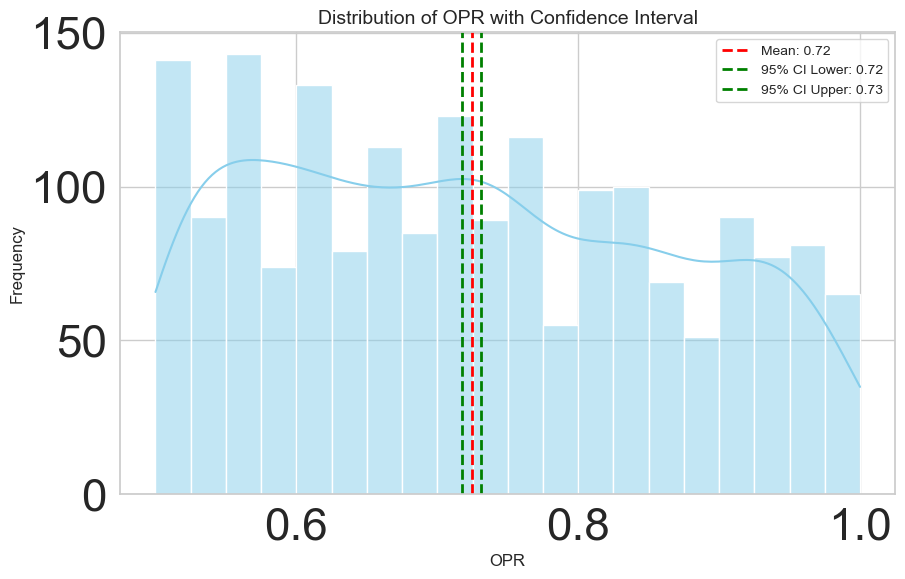

In [848]:
summary_stats = df_new['OPR'].describe()
print("Summary Statistics:")
print(summary_stats)

# Confidence Interval for Mean
mean = summary_stats['mean']
std_dev = summary_stats['std']
n = summary_stats['count']

confidence_level = 0.95
degrees_freedom = n - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean, scale=std_dev/np.sqrt(n))

print(f"\n95% Confidence Interval for Mean: {confidence_interval}")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_new['OPR'], bins=20, kde=True, color='skyblue')

# Mark mean and confidence interval
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Lower: {confidence_interval[0]:.2f}')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Upper: {confidence_interval[1]:.2f}')

plt.title('Distribution of OPR with Confidence Interval')
plt.xlabel('OPR')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Online:

Summary Statistics:
count    1873.000000
mean       48.840897
std        16.524499
min        13.000000
25%        37.000000
50%        47.000000
75%        58.000000
max       128.000000
Name: Online, dtype: float64

95% Confidence Interval for Mean: (48.0920580589596, 49.589735854548145)


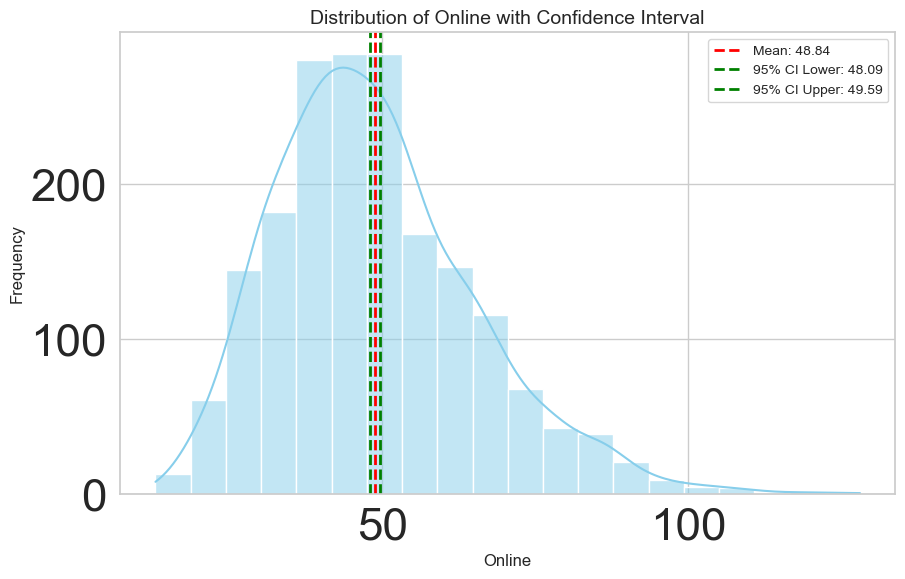

In [850]:
summary_stats = df_new['Online'].describe()
print("Summary Statistics:")
print(summary_stats)

# Confidence Interval for Mean
mean = summary_stats['mean']
std_dev = summary_stats['std']
n = summary_stats['count']

confidence_level = 0.95
degrees_freedom = n - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean, scale=std_dev/np.sqrt(n))

print(f"\n95% Confidence Interval for Mean: {confidence_interval}")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_new['Online'], bins=20, kde=True, color='skyblue')

# Mark mean and confidence interval
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Lower: {confidence_interval[0]:.2f}')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2, label=f'95% CI Upper: {confidence_interval[1]:.2f}')

plt.title('Distribution of Online with Confidence Interval')
plt.xlabel('Online')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Discount:

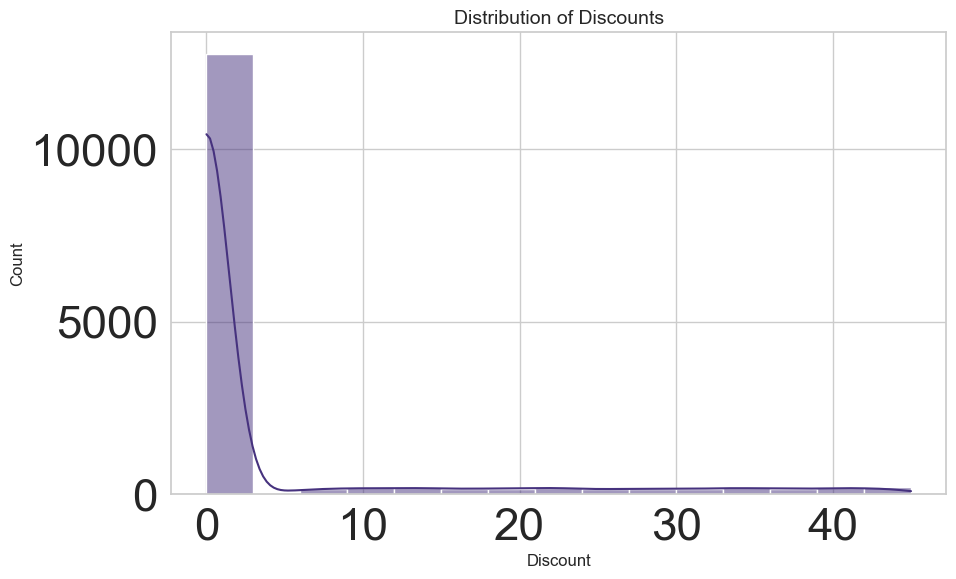

In [852]:
sns.histplot(df['Discount'], kde=True)
plt.title('Distribution of Discounts')
plt.xlabel('Discount')
plt.show()

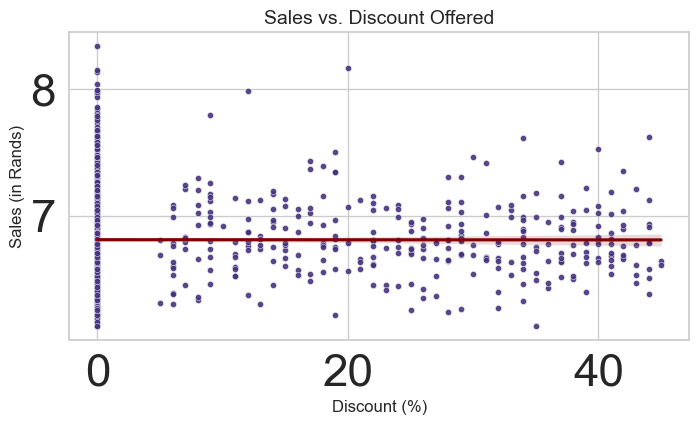

In [854]:
plt.figure(figsize=(8, 4)) 
sns.scatterplot(data=df_new, x='Discount', y='LogSales', alpha=0.9, marker='o', s=20)
sns.regplot(data=df_new, x='Discount', y='LogSales', scatter=False, color='maroon')
plt.title('Sales vs. Discount Offered')
plt.xlabel('Discount (%)')
plt.ylabel('Sales (in Rands)')
plt.show()

Discount is heavily skewed to the right. Businesses generally offer only a few high discounts to prevent profit loss. Most of the discounts offered to customers might be small, with only a few promotional campaigns or special offers providing large discounts. This could result in a few very high values, causing the right skew. We will perform another log transformation on Discount.

In [856]:
df_new['LogDiscount'] = np.log1p(df_new['Discount'])
quantiles = df_new['LogDiscount'].quantile([0, 0.25, 0.5, 0.75, 1])
print(quantiles)

0.00    0.000000
0.25    0.000000
0.50    0.000000
0.75    0.000000
1.00    3.828641
Name: LogDiscount, dtype: float64


In [874]:
def nominal_plots(var, df):
    sns.set(font_scale=3)
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(4, 4)
    ax1 = fig.add_subplot(gs[0:2, :])
    sns.boxplot(x='Sales', y=var, data=df_new, orient="h",ax=ax1)
    ticks = np.linspace(data_new['LogSales'].min(), data_new['LogSales'].max(), num=10)
    plt.xticks(rotation=45)
    ax1.set_title('Boxplot')

    plt.show()

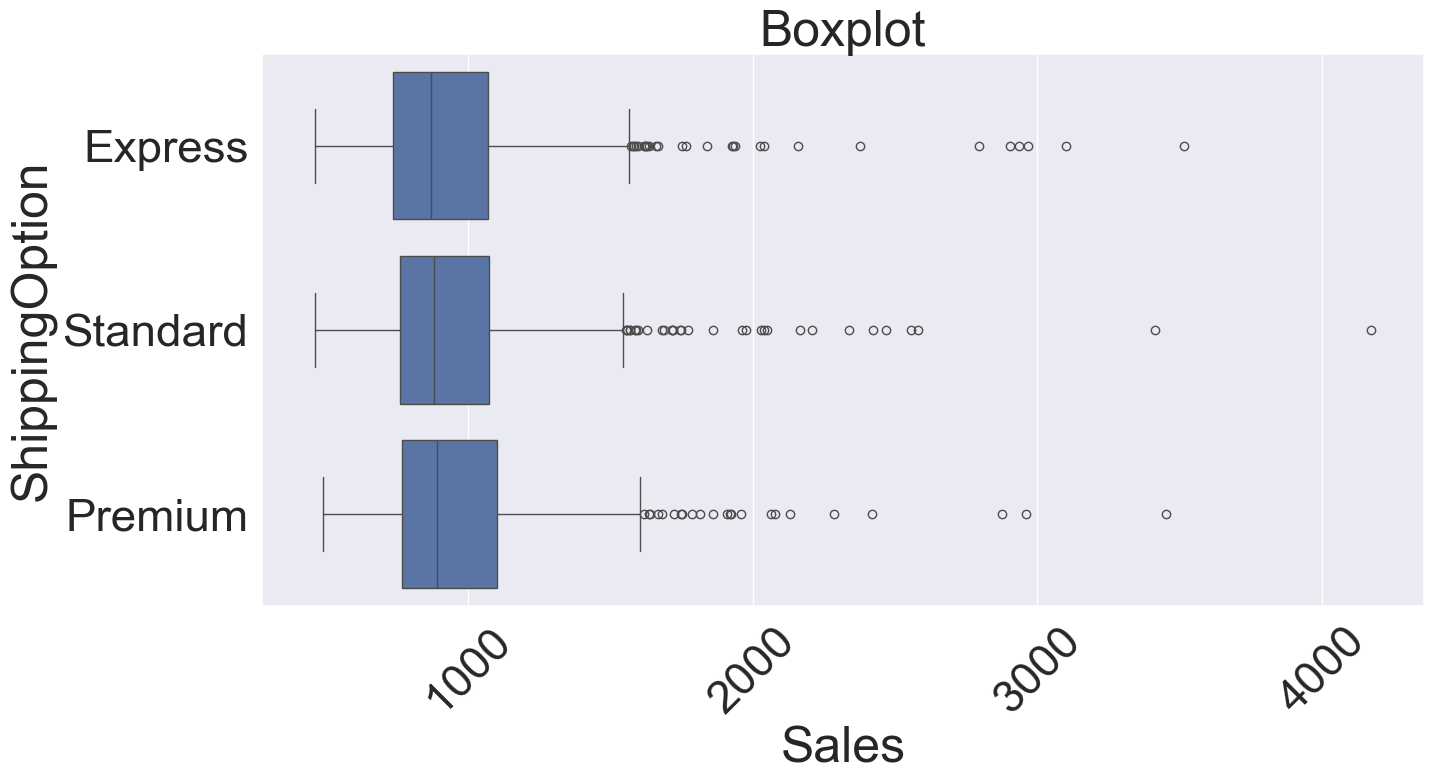

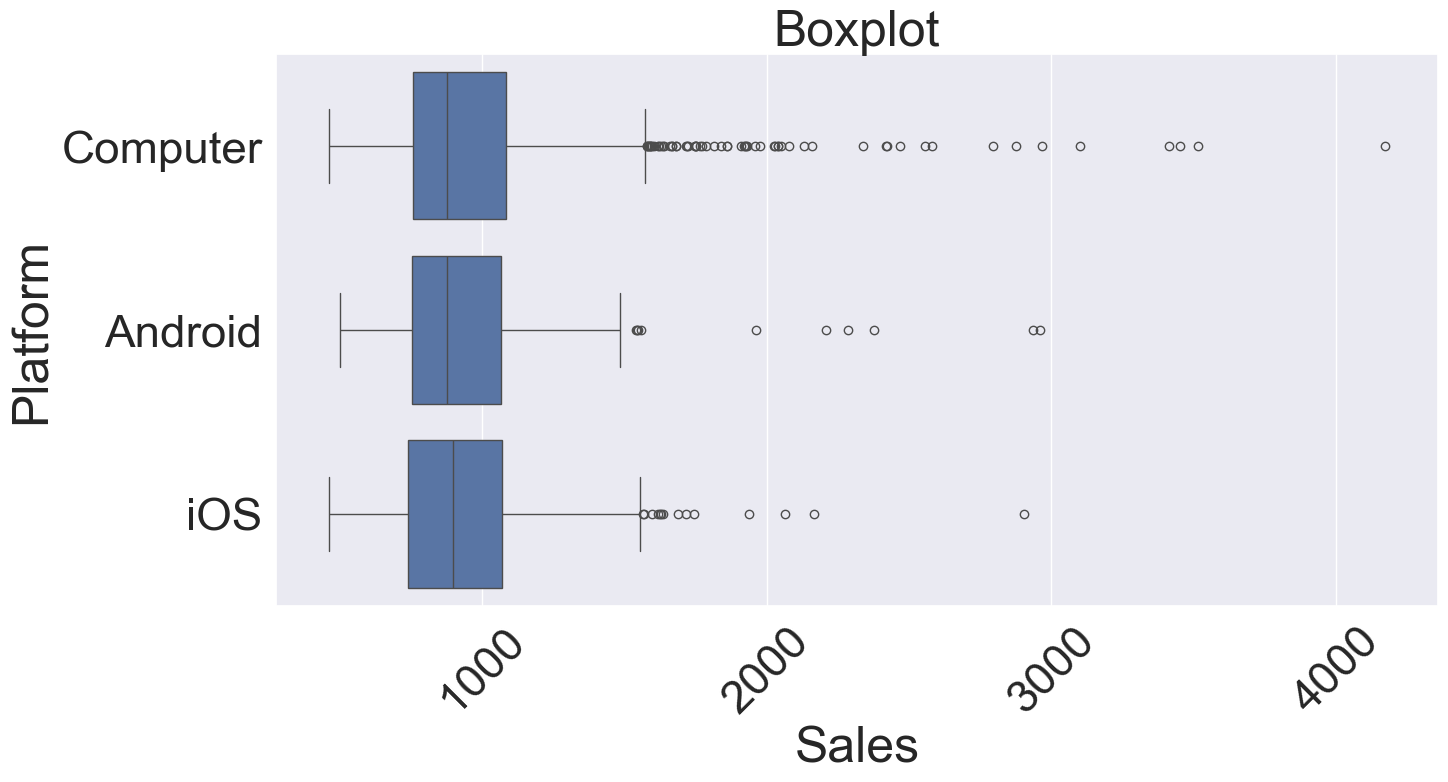

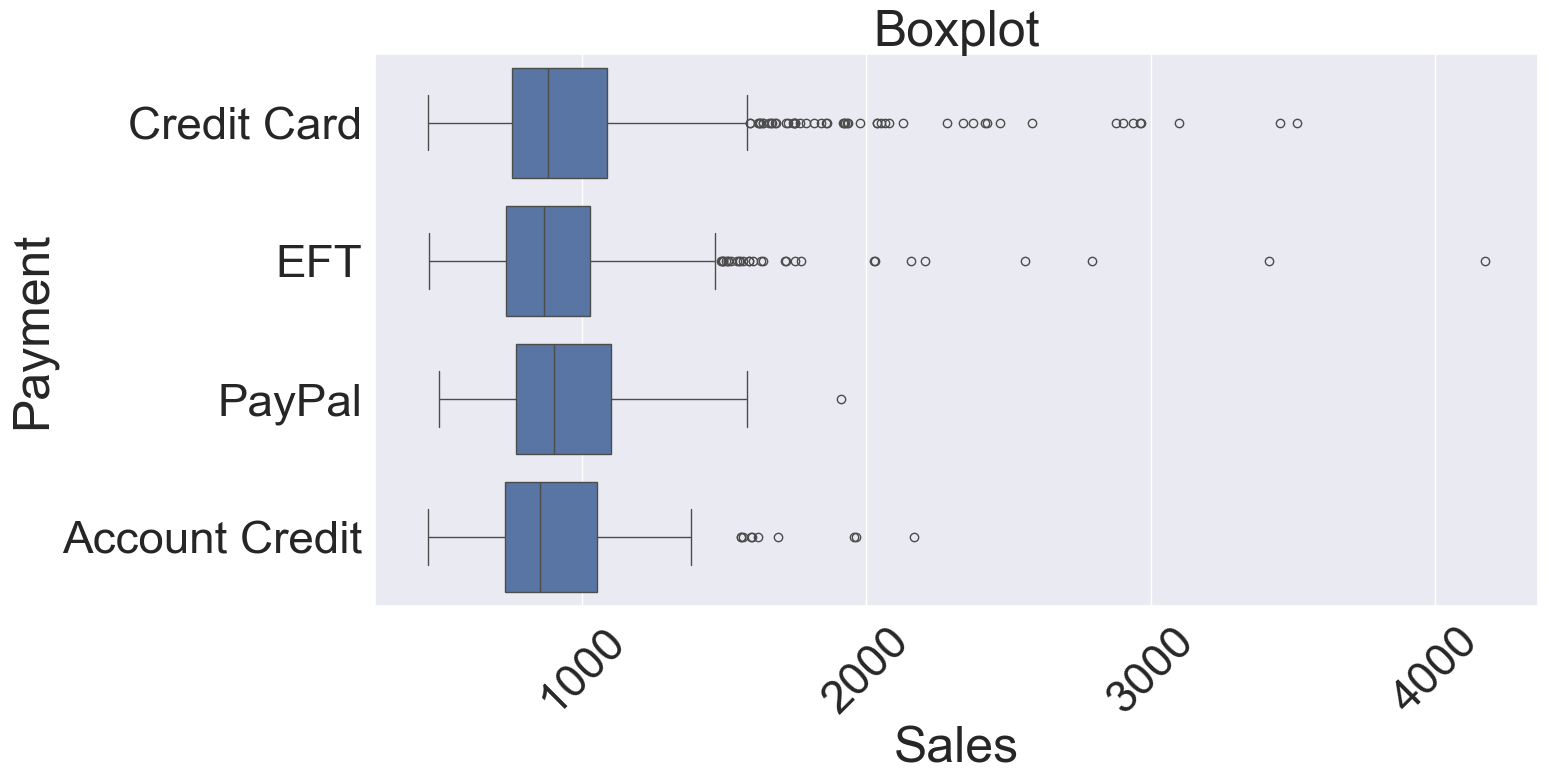

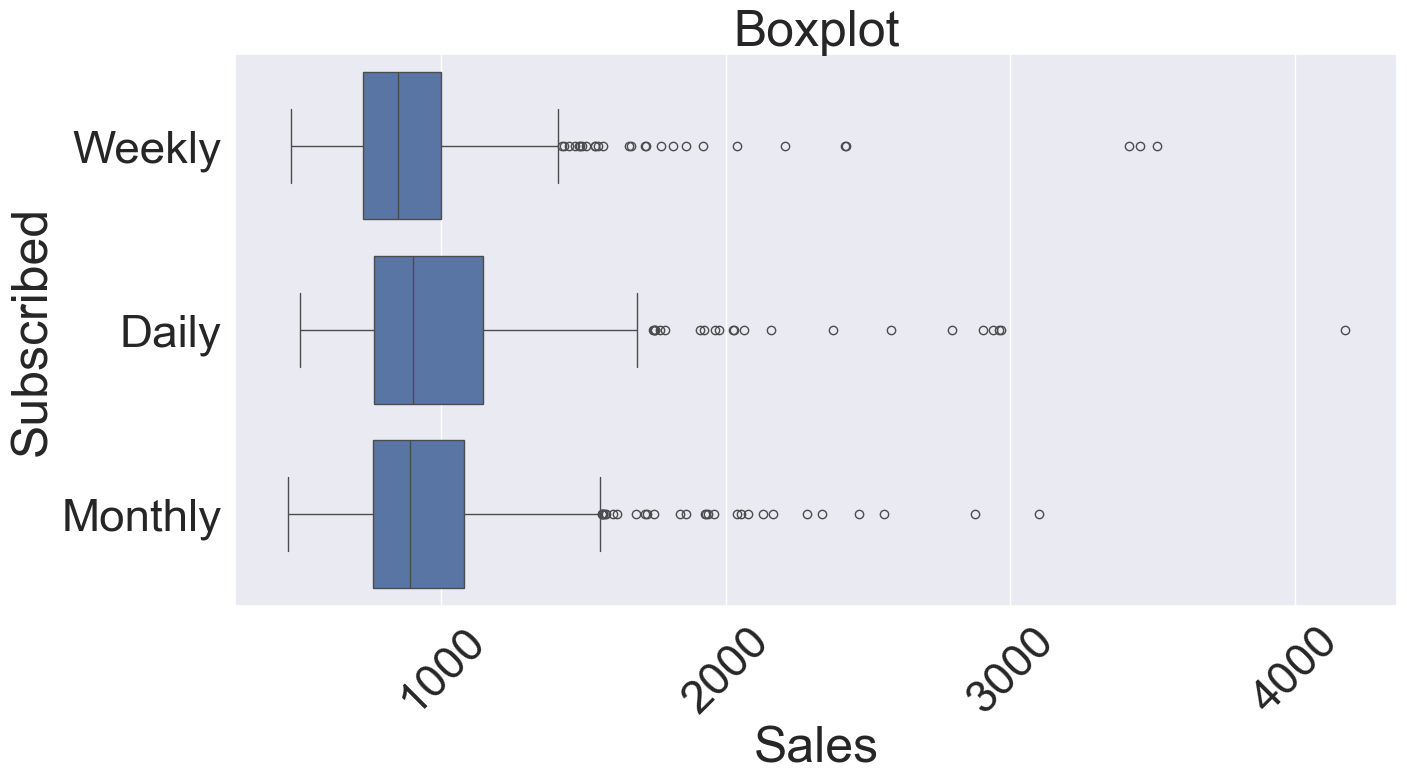

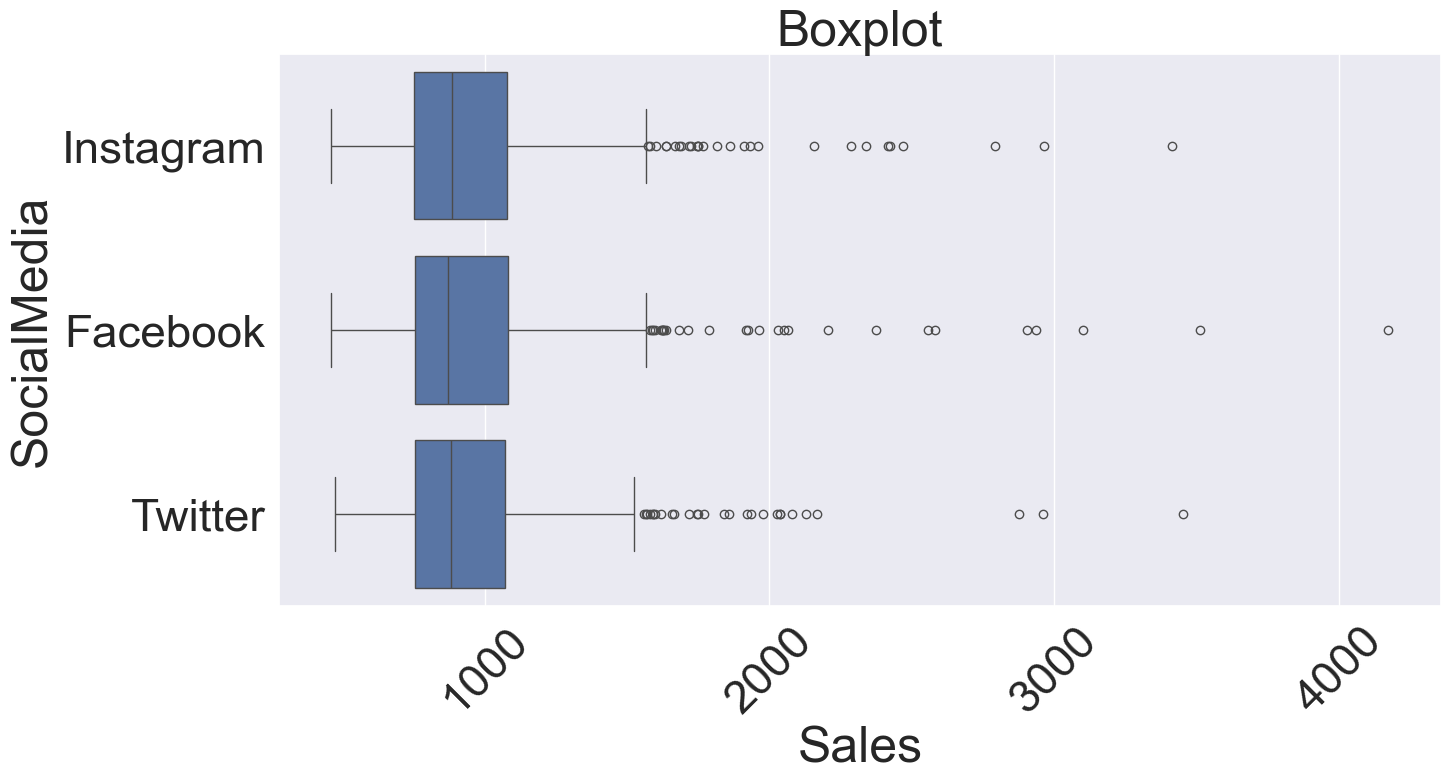

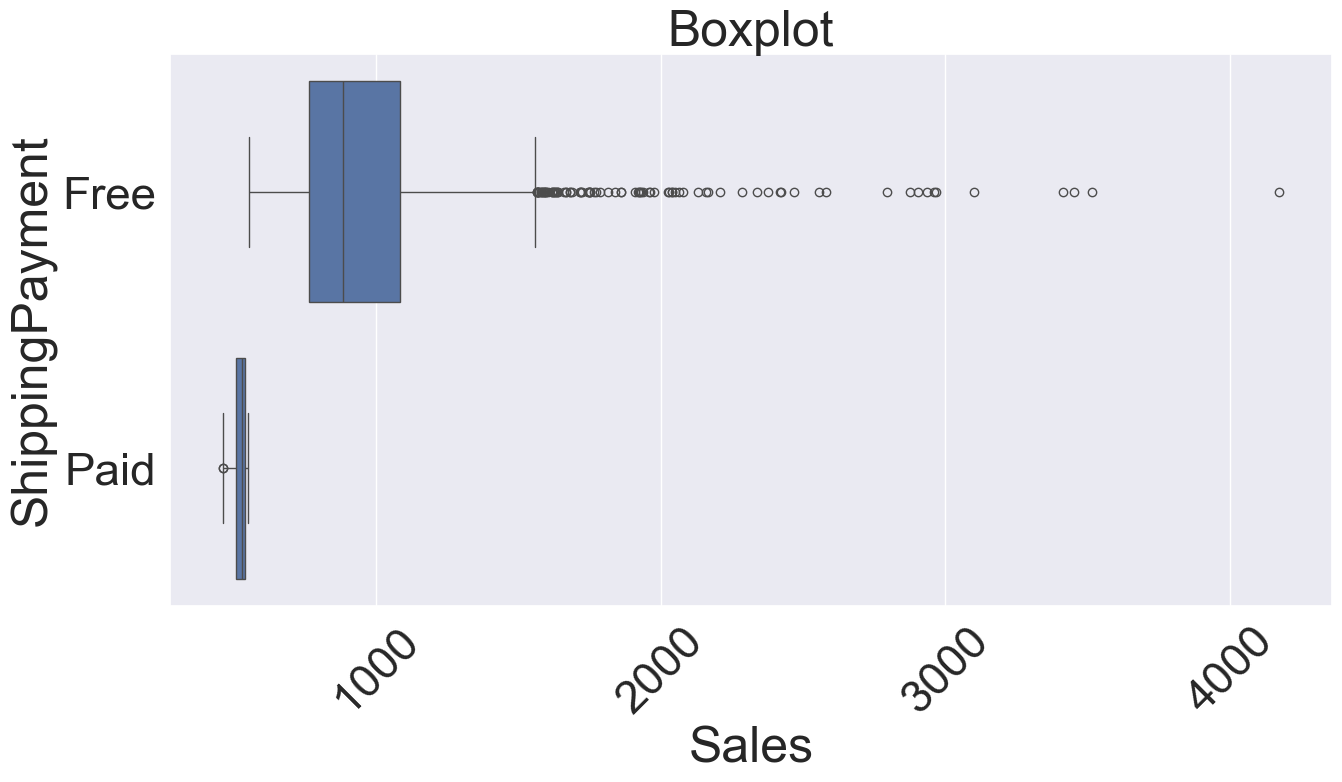

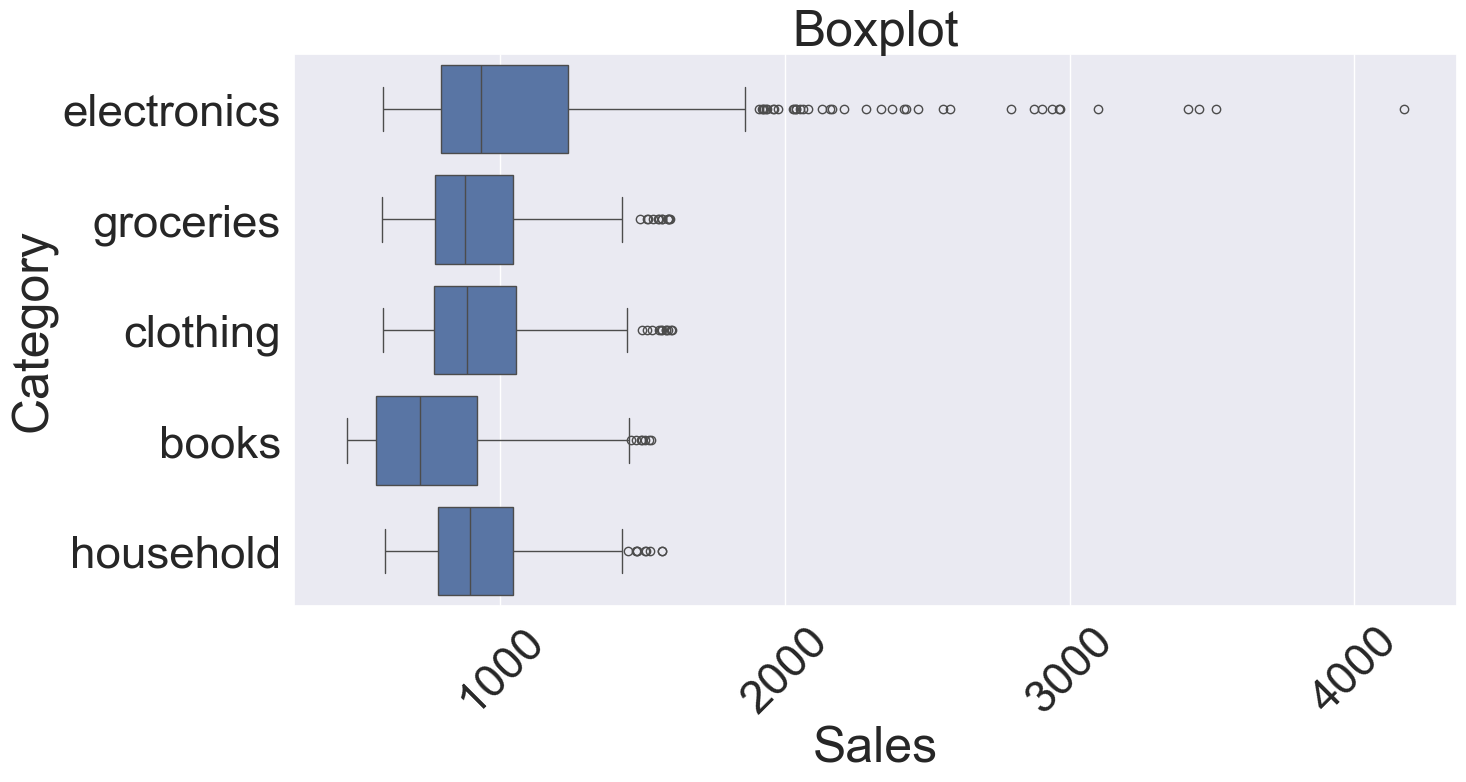

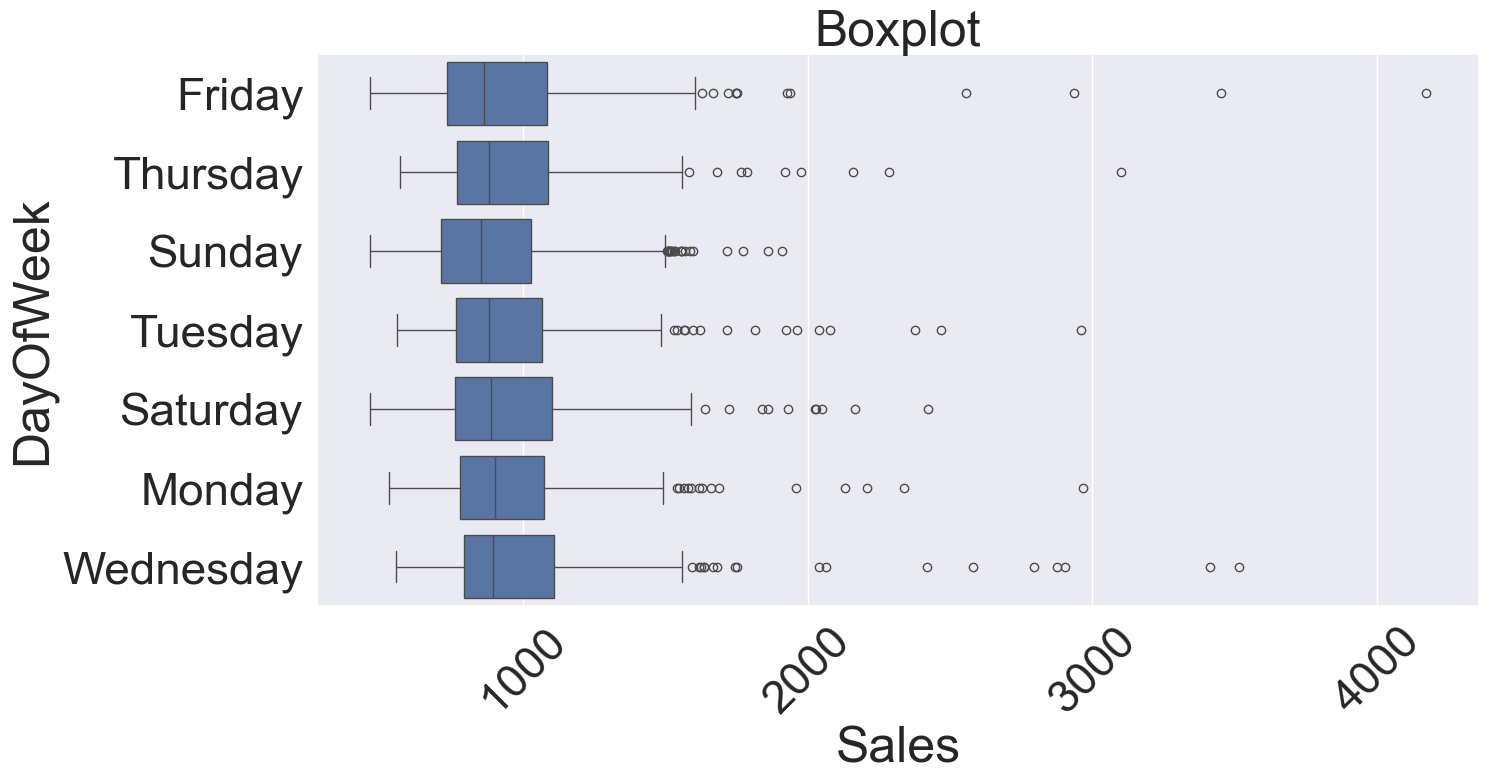

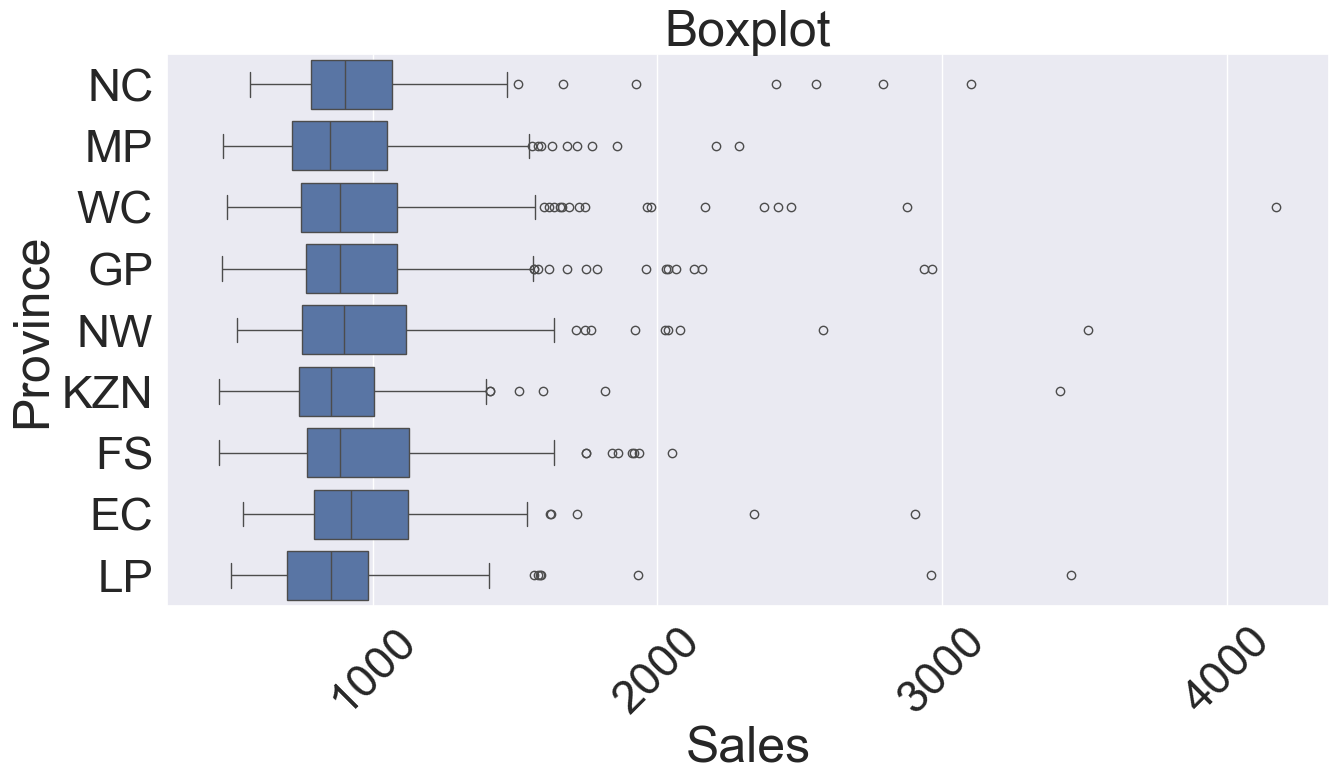

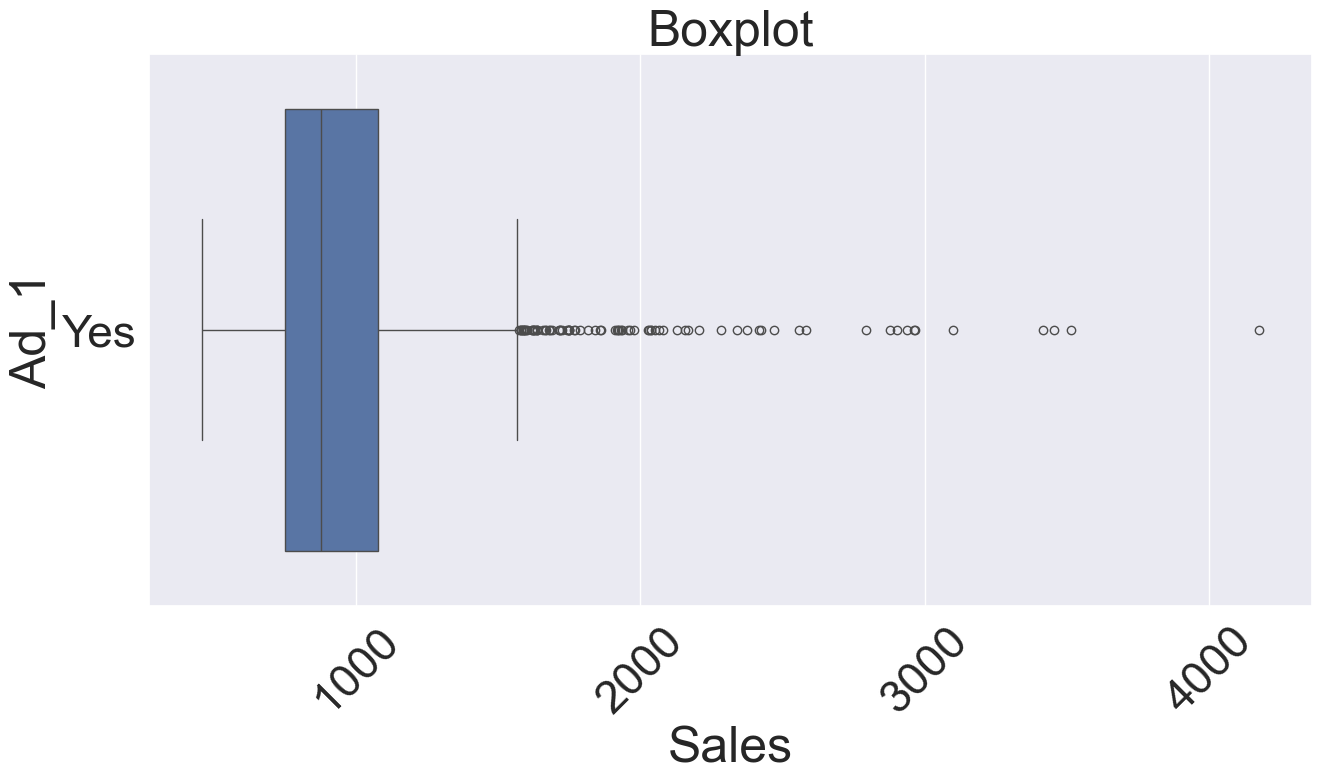

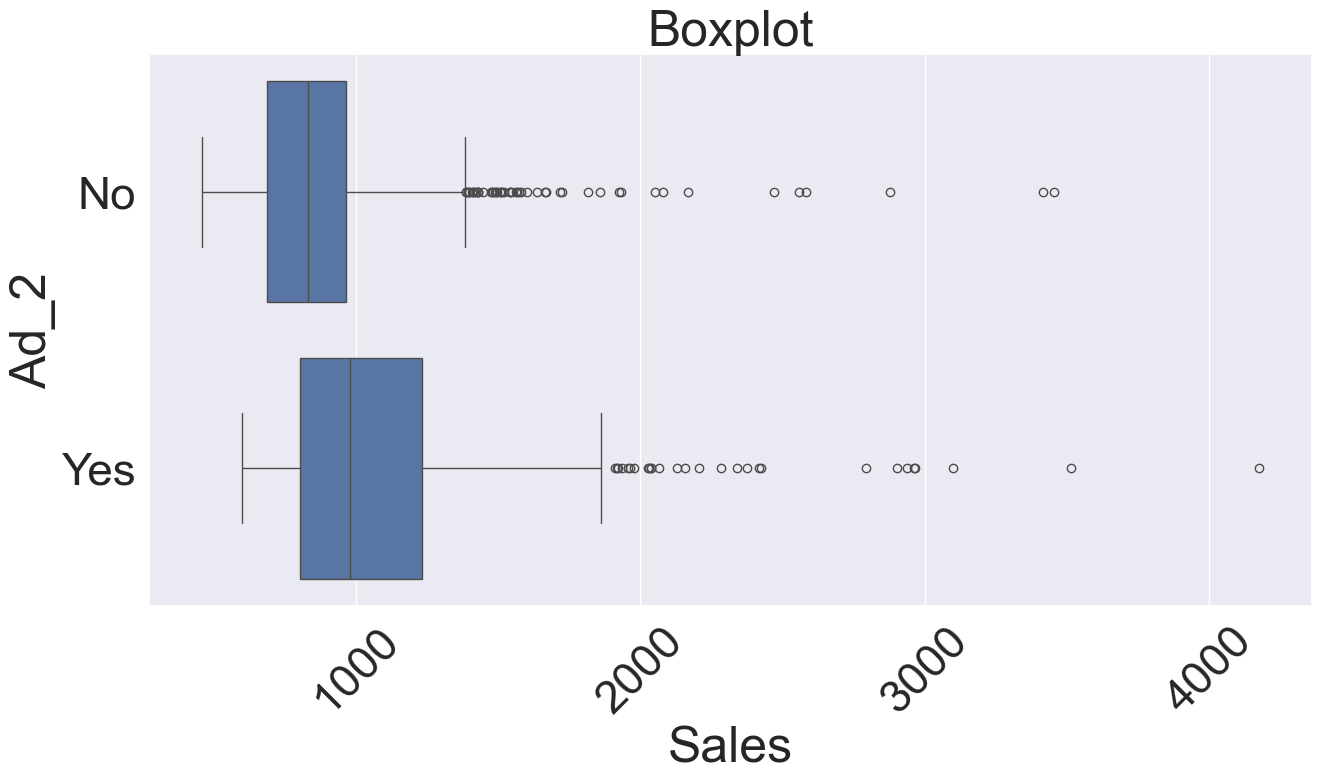

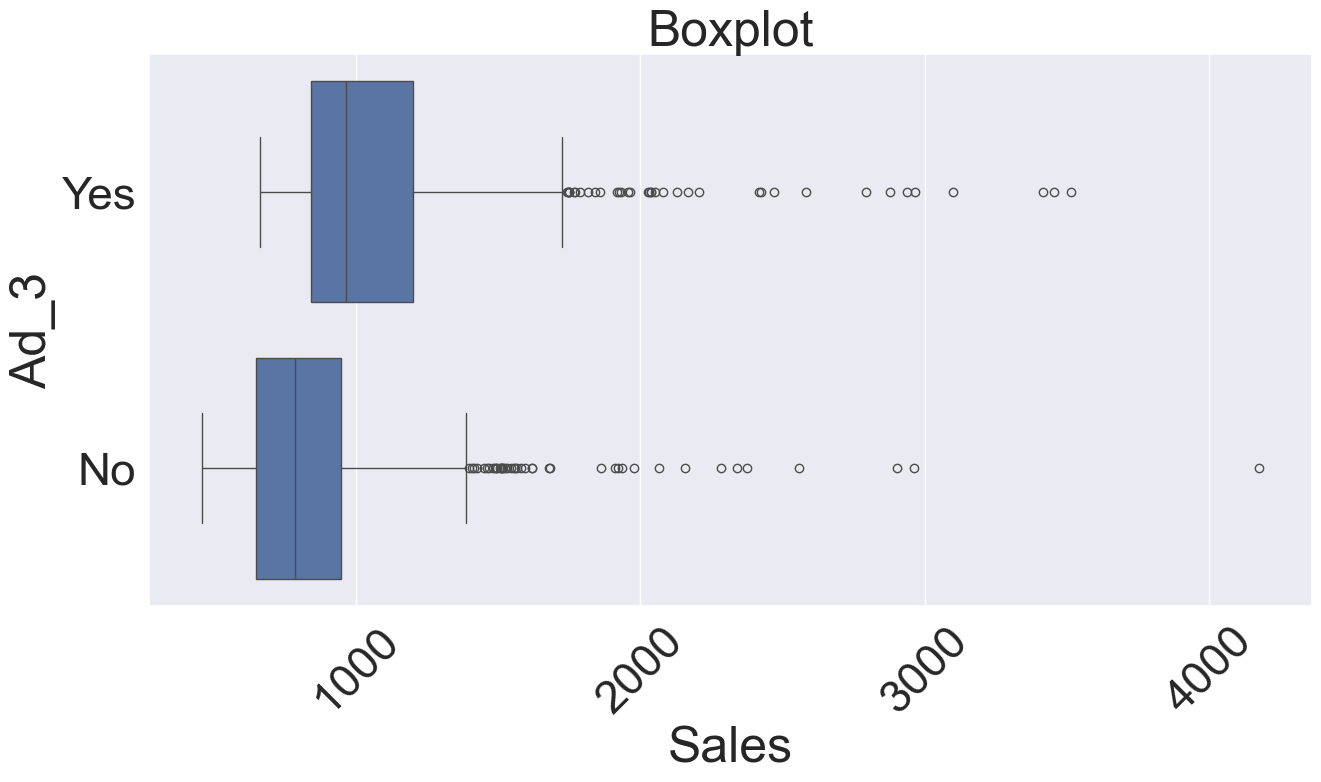

In [876]:
categorical = ['ShippingOption', 'Platform', 'Payment', 'Subscribed', 'SocialMedia', 'ShippingPayment', 'Category', 'DayOfWeek', 'Province',
              'Ad_1', 'Ad_2', 'Ad_3']
for var in categorical:
    nominal_plots(var, df)

# Data Processing

### CREATING DUMMY VARIABLES

In [878]:
df_dummies = pd.get_dummies(df_new, columns=['Season','Subscribed','ShippingOption','Ad_1','Ad_2','Ad_3', 'ShippingPayment', 'Province',
                                     'Platform','Payment','DayOfWeek', 'SocialMedia', 'Category'])
scaler = StandardScaler()
numerical = ['LogSales', 'AgeInMonths_Squared', 'PIM_NPR_interaction', 'AvgSpend', 'POSR', 'OPR', 'Online', 'LogDiscount']
df_dummies[numerical] = scaler.fit_transform(df_new[numerical])
df_dummies.head()

,Sales,AgeInMonths,ProfileInMonths,AvgSpend,POSR,OPR,Online,Discount,PIM_NPR_interaction,LogSales,...,DayOfWeek_Tuesday,DayOfWeek_Wednesday,SocialMedia_Facebook,SocialMedia_Instagram,SocialMedia_Twitter,Category_books,Category_clothing,Category_electronics,Category_groceries,Category_household
1,1668.01,305,56,0.968735,-1.490129,-1.208869,0.554422,31,0.587470,1.997613,...,False,False,False,True,False,False,False,True,False,False
4,669.82,403,46,-0.375555,1.959041,1.287887,0.493890,0,0.352631,-1.010286,...,False,False,True,False,False,False,False,True,False,False
10,943.18,385,20,-0.164964,-0.742808,1.565305,0.372825,0,-1.224147,0.117706,...,False,False,False,False,True,False,False,False,True,False
11,1006.73,389,10,-0.317208,-0.167947,1.149179,-0.232499,37,-1.382570,0.332664,...,True,False,False,True,False,False,True,False,False,False
41,857.27,468,52,0.066142,-0.052974,-1.000806,0.191228,0,1.072059,-0.197107,...,False,False,True,False,False,True,False,False,False,False


### PARTITIONING DATA

Splitting the data into training and test sets using 80/20 split:

In [880]:
predictors = df_dummies.drop('Sales', axis=1)
target = df_dummies[['Sales']]
x_train, x_test, y_train, y_test = train_test_split(predictors ,target ,test_size =0.2, random_state=42)